<a href="https://colab.research.google.com/github/wayne-chi/Election_ETL_Pipeline_1/blob/main/election_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymongo[srv]
!pip install load_dotenv

In [2]:
from pymongo import MongoClient

import pandas as pd
import numpy as np
import sys
import os

from dotenv import load_dotenv

import plotly.express as px


load_dotenv()

False

In [4]:
client = MongoClient(os.getenv('MONGODB_analyst_URI'))

In [5]:
result = client['election']['poolingUnits'].aggregate([
    {
        '$match': {
            'State': 'RIVERS',
            'location': {
                '$exists': 1
            }
        }
    }, {
        '$lookup': {
            'from': 'poolingUnits',
            'let': {
                'filtered_loc': '$location',
                'filtered_id': '$_id'
            },
            'pipeline': [
                {
                    '$geoNear': {
                        'near': '$$filtered_loc',
                        'distanceField': 'distance',
                        'maxDistance': 3000,
                        'query': {
                            '$expr': {
                                '$ne': [
                                    '$_id', '$$filtered_id'
                                ]
                            }
                        }
                    }
                }, {
                    '$project': {
                        'APC': 1,
                        '_id': 0,
                        'LP': 1,
                        'PDP': 1,
                        'NNPP': 1,
                        'total': {
                            '$sum': [
                                '$APC', '$LP', '$PDP', '$NNPP'
                            ]
                        }
                    }
                }
            ],
            'as': 'result'
        }
    }, {
        '$project': {
            'Latitude': {
                '$arrayElemAt': [
                    '$location.coordinates', 1
                ]
            },
            'Longitude': {
                '$arrayElemAt': [
                    '$location.coordinates', 0
                ]
            },
            'PU-Code': 1,
            'PU-Name': 1,
            'State': 1,
            'LGA': 1,
            'Ward': 1,
            'APC': 1,
            'PDP': 1,
            'LP': 1,
            'NNPP': 1,
            'count': {
                '$size': '$result'
            },
            'total': {
                '$sum': [
                    '$APC', '$LP', '$PDP', '$NNPP'
                ]
            },
            'APC_mean': {
                '$avg': '$result.APC'
            },
            'APC_std': {
                '$stdDevPop': '$result.APC'
            },
            'PDP_mean': {
                '$avg': '$result.PDP'
            },
            'PDP_std': {
                '$stdDevPop': '$result.PDP'
            },
            'LP_mean': {
                '$avg': '$result.LP'
            },
            'LP_std': {
                '$stdDevPop': '$result.LP'
            },
            'NNPP_mean': {
                '$avg': '$result.NNPP'
            },
            'NNPP_std': {
                '$stdDevPop': '$result.NNPP'
            },
            'total_mean': {
                '$avg': '$result.total'
            },
            'total_std': {
                '$stdDevPop': '$result.total'
            },
            '_id': 0
        }
    }
])

In [6]:
#
df = pd.DataFrame(list(result))


In [7]:
df.to_csv('analyze.csv')

In [8]:
df

,State,LGA,Ward,PU-Code,PU-Name,APC,LP,PDP,NNPP,Latitude,...,APC_mean,APC_std,PDP_mean,PDP_std,LP_mean,LP_std,NNPP_mean,NNPP_std,total_mean,total_std
0,RIVERS,ABUA-ODUAL,ABUA I,32-01-01-001,"OGBEMA I, TOWN HALL",0,0,0,0,4.812850,...,8.750000,5.261891,24.500000,23.350589,2.250000,1.920286,0.000000,0.000000,35.500000,29.542342
1,RIVERS,ABUA-ODUAL,ABUA I,32-01-01-002,"OGBEMA II, C.P.S HALL",0,0,0,0,4.812850,...,8.750000,5.261891,24.500000,23.350589,2.250000,1.920286,0.000000,0.000000,35.500000,29.542342
2,RIVERS,ABUA-ODUAL,ABUA I,32-01-01-003,"OGBEMA III, C.P.S HALL",10,1,17,0,4.812850,...,6.250000,6.339361,20.250000,25.752427,2.000000,2.121320,0.000000,0.000000,28.500000,33.537293
3,RIVERS,ABUA-ODUAL,ABUA I,32-01-01-004,"OGBEMA IV, TOWN HALL",14,5,63,0,4.812850,...,5.250000,5.261891,8.750000,8.757140,1.000000,1.224745,0.000000,0.000000,15.000000,15.066519
4,RIVERS,ABUA-ODUAL,ABUA I,32-01-01-005,IGUTA ADAUYO TOWN HALL I,5,0,41,0,4.857630,...,19.640000,21.022616,30.980000,24.470791,8.100000,8.902247,0.680000,3.781217,59.400000,41.697002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4764,RIVERS,TAI,OYIGBO WEST,32-23-08-009,"C.P.S. FIELD I, BARAYIRA",41,4,6,0,4.732011,...,55.557143,56.892790,12.757143,23.980609,8.528571,52.376309,0.128571,0.843825,76.971429,73.511898
4765,RIVERS,TAI,OYIGBO WEST,32-23-08-011,"BUE EEDEE OPEN SPACE, SIME",10,1,5,0,4.732011,...,56.000000,56.656610,12.771429,23.976281,8.571429,52.371358,0.128571,0.843825,77.471429,73.213918
4766,RIVERS,TAI,OYIGBO WEST,32-23-08-012,"MARKET SQUARE, SIME",7,1,2,0,4.746360,...,25.500000,32.134094,24.375000,17.932774,8.325000,6.314220,0.050000,0.217945,58.250000,39.112498
4767,RIVERS,TAI,OYIGBO WEST,32-23-08-013,". BUE-ZOR OPEN SPACE, BY NEW APOSTOLIC CHURCH,...",22,3,13,0,4.732011,...,55.828571,56.777252,12.657143,23.993979,8.542857,52.374936,0.128571,0.843825,77.157143,73.429584


In [9]:
df.columns

Index(['State', 'LGA', 'Ward', 'PU-Code', 'PU-Name', 'APC', 'LP', 'PDP',
       'NNPP', 'Latitude', 'Longitude', 'count', 'total', 'APC_mean',
       'APC_std', 'PDP_mean', 'PDP_std', 'LP_mean', 'LP_std', 'NNPP_mean',
       'NNPP_std', 'total_mean', 'total_std'],
      dtype='object')

In [10]:

def replace_zero_std(df):
  for col in ['APC_std', 'LP_std', 'NNPP_std', 'PDP_std']:
    df.loc[df[col] == 0, col] = 1
  return df

df = replace_zero_std(df)


In [11]:
# prompt: create column Z_APC as the APC column - APC_mean column divided by APC_std d do similar for LP, NNPC, PDP

df['Z_APC'] = abs(df['APC'] - df['APC_mean']) / df['APC_std']
df['Z_LP'] =abs(df['LP'] - df['LP_mean']) / df['LP_std']
df['Z_NNPP'] = abs(df['NNPP'] - df['NNPP_mean']) / df['NNPP_std']
df['Z_PDP'] = abs(df['PDP'] - df['PDP_mean']) / df['PDP_std']
df['Z_total'] = (df['total'] - df['total_mean']) / df['total_std']
df['Name'] = df['PU-Name'] + ', ' + df['LGA']
df.fillna(0, inplace=True)


In [12]:
# prompt: subset df to adf include PU-Name, 'Latitude', 'Longitude', 'Z_APC', 'Z_LP', 'Z_NNPP', 'Z_PDP',
#        'Z_total'

adf = df[['Name', 'Latitude', 'Longitude', 'Z_APC', 'Z_LP', 'Z_NNPP', 'Z_PDP',
       'Z_total']]
adf.head()

,Name,Latitude,Longitude,Z_APC,Z_LP,Z_NNPP,Z_PDP,Z_total
0,"OGBEMA I, TOWN HALL, ABUA-ODUAL",4.81285,6.60239,1.662900,1.171700,0.000000,1.049224,-1.201665
1,"OGBEMA II, C.P.S HALL, ABUA-ODUAL",4.81285,6.60239,1.662900,1.171700,0.000000,1.049224,-1.201665
2,"OGBEMA III, C.P.S HALL, ABUA-ODUAL",4.81285,6.60239,0.591542,0.471405,0.000000,0.126202,-0.014909
3,"OGBEMA IV, TOWN HALL, ABUA-ODUAL",4.81285,6.60239,1.662900,3.265986,0.000000,6.194945,4.446946
4,"IGUTA ADAUYO TOWN HALL I, ABUA-ODUAL",4.85763,6.64519,0.696393,0.909883,0.179836,0.409468,-0.321366


In [13]:
thresh = 5
count_threshold = 3

In [14]:
min_lat = df['Latitude'].min()
max_lat = df['Latitude'].max()
min_long = df['Longitude'].min()
max_long = df['Longitude'].max()



In [15]:
color_scale = [
     [0, 'rgba(125, 0, 0, 0.3)'],
     [0.2, 'rgba(150, 0, 0, 0.4)'],
     [0.4, 'rgba(200, 0, 0, 0.5)'],
     [0.6, 'rgba(255, 0, 0, 0.6)'],
    [0.8, 'rgba(255, 0, 0, 0.8)'],
    [1, 'rgba(255, 0, 0, 1)'],
]


## Top 5 outliers for each Party.

### Top 5 APC Outliers

In [16]:
Pl_APC_df = df[(df['Z_APC'] > thresh) & (df['count']>=count_threshold)].sort_values(by='Z_APC', ascending=False)
Pl_APC_df[['Name', 'Latitude', 'Longitude', 'Z_APC','APC','APC_mean','APC_std','count']].head()

,Name,Latitude,Longitude,Z_APC,APC,APC_mean,APC_std,count
2524,"VILLAGE SQUARE, OYIGBO",4.874907,7.134533,153.202323,500,1.840909,3.251642,132
1327,"AGWUO/AWHUA OMAGWA, IKWERRE",5.020634,6.874301,38.061114,191,13.750000,4.656984,4
60,"AGADA I, SCHOOL HALL, ABUA-ODUAL",4.801506,6.687099,33.798165,562,21.800000,15.983116,20
96,"STATE SCHOOL HALL, OKOLOMADE II, ABUA-ODUAL",4.821016,6.511460,13.268363,81,21.333333,4.496913,3
1665,"MGBUCHI/ELEDO TOWN RUKPOKU, OBIO/AKPOR",4.924600,6.995200,12.578233,299,16.134615,22.488483,52


In [17]:
apc_total_outliers = len(Pl_APC_df)
apc_mean_z  = Pl_APC_df['Z_APC'].mean()
apc_std_z = Pl_APC_df['Z_APC'].std()
print(apc_total_outliers)

45


Extra:
- Because some values have very few counts they tend to have high Z values : some areas that arent so accessible may have only a few centres.
- for better insight I have also excluded those with lower counts

In [36]:
fig = px.scatter_geo(  Pl_APC_df,
                     lon ='Longitude', lat = 'Latitude',
                       size= 'APC', color = 'Z_APC',
                       hover_name = 'Name',
                     title = ' Distribution of  Outliers in the APC Party',
                     projection = 'natural earth',
                       color_continuous_scale=color_scale,
                       )


fig.update_geos(
  center = dict(
      lat =4.7639, #(min_lat + max_lat)/2,
      lon = 6.9523 #(min_long+max_long)/2,
  ),
  projection_scale = 15,

showland = True,
landcolor = 'lightgreen',
  showocean = True,
  oceancolor = 'lightblue',
  showlakes = True,
  lakecolor = 'lightblue',
  showcountries = True,
  showrivers = True,
  rivercolor = 'blue',
 )
fig.update_layout(
    title_x=0.5,
     title_xanchor = 'center',
)


fig.show()



The max value of the outlier score is around 140, A majority of the outlier values are less than 20.
The red shows areas with very high abnormaity.

### Top 5 PDP Outlier

In [19]:
# ### Top 5 PDP Outliers
Pl_PDP_df = df[(df['Z_PDP'] > thresh) & (df['count']>=count_threshold)].sort_values(by='Z_PDP', ascending=False)
Pl_PDP_df[['Name', 'Latitude', 'Longitude', 'Z_PDP','PDP','PDP_mean','PDP_std','count']].head()


,Name,Latitude,Longitude,Z_PDP,PDP,PDP_mean,PDP_std,count
4191,0PEN SPACE BY 76 NVUIGWE RD BESIDE POLICE POST...,4.855528,6.994628,43.487272,243,3.411141,5.509402,377
2268,"UMUMBRA TOWN HALL UMUOLA, OMUMA",4.890700,7.030380,29.393877,25,1.000000,0.816497,3
637,"OKAMA/ POLOKIRI VILLAGE SQUARE, ANDONI",4.511998,7.382942,26.217515,392,16.896000,14.307382,125
41,"OKOBOH TOWN HALL, ABUA-ODUAL",4.884460,6.618440,22.864577,152,6.142857,6.379175,7
428,"PEDRO'S COMPOUND BENIBO, AKUKU TORU",4.539604,6.747379,22.566498,272,14.480769,11.411573,156


In [20]:
pdp_total_outliers = len(Pl_PDP_df)
pdp_mean_z = Pl_PDP_df['Z_PDP'].mean()
pdp_std_z = Pl_PDP_df['Z_PDP'].std()
print(pdp_total_outliers)


38


In [21]:

fig = px.scatter_geo(  Pl_PDP_df,
                     lon ='Longitude', lat = 'Latitude',
                       size= 'PDP', color = 'Z_PDP',
                       hover_name = 'Name',
                     title = ' Plot of  Outliers in the PDP Party',

                     projection = 'natural earth',
                       color_continuous_scale=color_scale,
                       )
fig.update_layout(
    title_x=0.5,
     title_xanchor = 'center',
)

fig.update_geos(
  center = dict(
      lat =4.7639, #(min_lat + max_lat)/2,
      lon = 6.9523 #(min_long+max_long)/2,
  ),
  projection_scale = 15,

showland = True,
landcolor = 'lightgreen',
  showocean = True,
  oceancolor = 'lightblue',
  showlakes = True,
  lakecolor = 'lightblue',
  showcountries = True,
  showrivers = True,
  rivercolor = 'blue',

)

fig.show()




### NNPP
####  TOP 5 Outliers For NNPP

In [22]:
Pl_NNPP_df = df[(df['Z_NNPP'] > thresh) & (df['count']>=count_threshold)].sort_values(by='Z_NNPP', ascending=False)
Pl_NNPP_df[['Name', 'Latitude', 'Longitude', 'Z_NNPP','NNPP','NNPP_mean','NNPP_std','count']].head()


,Name,Latitude,Longitude,Z_NNPP,NNPP,NNPP_mean,NNPP_std,count
359,"TOWN HALL, EGBEE, AHOADA WEST",5.043357,6.504660,261.817973,54,0.044444,0.206080,90
2524,"VILLAGE SQUARE, OYIGBO",4.874907,7.134533,78.737036,60,0.303030,0.758182,132
2957,"ABULOMA UPE III, PORT HARCOURT",4.779366,7.060843,68.967888,28,0.136364,0.404009,44
44,"STATE SCHOOL HALL, OBARANY, ABUA-ODUAL",4.857630,6.645190,67.066220,27,0.140000,0.400500,50
2886,"KENNETH COMMERCIAL SCHOOL I, PORT HARCOURT",4.789949,6.988290,50.191187,25,0.204082,0.494029,147


In [23]:
nnpp_total_outliers = len(Pl_NNPP_df)
nnpp_mean_z = Pl_NNPP_df['Z_NNPP'].mean()
nnpp_std_z = Pl_NNPP_df['Z_NNPP'].std()
print(nnpp_total_outliers)

56


In [24]:

# ### Top 5 NNPP Outliers


fig = px.scatter_geo(  Pl_NNPP_df,
                     lon ='Longitude', lat = 'Latitude',
                       size= 'NNPP', color = 'Z_NNPP',
                       hover_name = 'Name',
                     title = ' Distribution of  Outliers in the NNPP Party',
                     projection = 'natural earth',
                       color_continuous_scale=color_scale,
                       )


fig.update_geos(
  center = dict(
      lat =4.7639, #(min_lat + max_lat)/2,
      lon = 6.9523 #(min_long+max_long)/2,
  ),
  projection_scale = 15,

showland = True,
landcolor = 'lightgreen',
  showocean = True,
  oceancolor = 'lightblue',
  showlakes = True,
  lakecolor = 'lightblue',
  showcountries = True,
  showrivers = True,
  rivercolor = 'blue',
 )

fig.update_layout(
    title_x=0.5,
     title_xanchor = 'center',
)

fig.show()

### LP

#### TOP 5 LP Outliers

In [25]:
# ### Top 5 LP Outliers
Pl_LP_df = df[(df['Z_LP'] > thresh) & (df['count']>=count_threshold)].sort_values(by='Z_LP', ascending=False)
Pl_LP_df[['Name', 'Latitude', 'Longitude', 'Z_LP','LP','LP_mean','LP_std','count']].head()





,Name,Latitude,Longitude,Z_LP,LP,LP_mean,LP_std,count
2971,"C.P.S I, BOTEM, TAI",4.730900,7.27657,114.054974,443,2.825000,3.859323,80
357,"TOWN HALL, OGODA, AHOADA WEST",5.115790,6.57502,28.730584,76,4.333333,2.494438,3
3112,"COMM. PRI. SCH. ISHIAYI, AHOADA WEST",5.043357,6.50466,16.045960,490,24.022222,29.040194,90
96,"STATE SCHOOL HALL, OKOLOMADE II, ABUA-ODUAL",4.821016,6.51146,15.202796,15,0.666667,0.942809,3
41,"OKOBOH TOWN HALL, ABUA-ODUAL",4.884460,6.61844,13.736956,57,4.857143,3.795809,7


In [26]:
lp_total_outliers = len(Pl_LP_df)

lp_mean_z = Pl_LP_df['Z_LP'].mean()
lp_std_z = Pl_LP_df['Z_LP'].std()
print(lp_total_outliers)

34


In [27]:
fig = px.scatter_geo(  Pl_LP_df,
                     lon ='Longitude', lat = 'Latitude',
                       size= 'LP', color = 'Z_LP',
                       hover_name = 'Name',
                     title = ' Distribution of  Outliers in the LP Party',
                     projection = 'natural earth',
                       color_continuous_scale=color_scale,
                       )


fig.update_geos(
  center = dict(
      lat =4.7639,
      lon = 6.9523
  ),
  projection_scale = 15,

showland = True,
landcolor = 'lightgreen',
  showocean = True,
  oceancolor = 'lightblue',
  showlakes = True,
  lakecolor = 'lightblue',
  showcountries = True,
  showrivers = True,
  rivercolor = 'blue',
 )
fig.update_layout(
    title_x=0.5,
     title_xanchor = 'center',
)


fig.show()

In [28]:
#

## Comparison Accross Parties

### Parties With the highest Number of outliers

In [29]:

party_outliers = {
    "APC": apc_total_outliers,
    "PDP": pdp_total_outliers,
    "NNPP": nnpp_total_outliers,
    "LP": lp_total_outliers,
}



In [30]:
import matplotlib.pyplot as plt

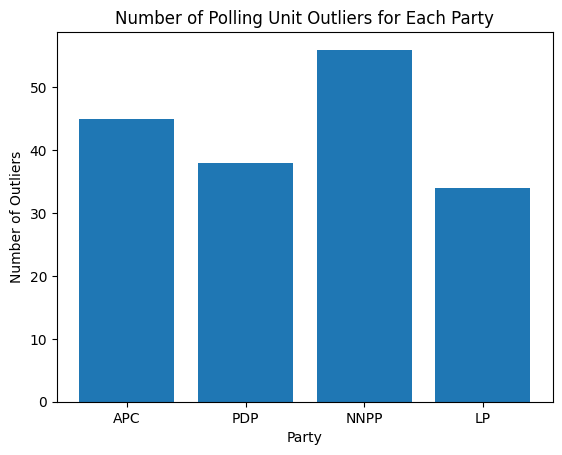

In [31]:
plt.bar(party_outliers.keys(), party_outliers.values())
plt.xlabel('Party')
plt.ylabel('Number of Outliers')
plt.title('Number of Polling Unit Outliers for Each Party')
plt.show()

In [32]:
print (party_outliers)

{'APC': 45, 'PDP': 38, 'NNPP': 56, 'LP': 34}


Summary
The break down of the number of polling units with outliers is presented below
- APC : 45
- PDP : 38
- NNPP : 56
- LP : 36 \

In Summary NNPP has the highest occurence of outlier in a polling unit

### Parties With Huge outliers

In [33]:
agg =  df[['Z_APC', 'Z_PDP', 'Z_LP', 'Z_NNPP']].agg(['mean','std'])

agg.rename(columns={'Z_APC': 'APC', 'Z_PDP': 'PDP', 'Z_LP': 'LP', 'Z_NNPP': 'NNPP',}, inplace=True)

agg = agg.T
agg.reset_index(inplace=True, drop=False)
agg.rename(columns={'index': 'Party'}, inplace=True)

agg

,Party,mean,std
0,APC,1.184087,9.394674
1,PDP,0.894080,2.924938
2,LP,1.002049,3.340642
3,NNPP,0.638286,4.566694


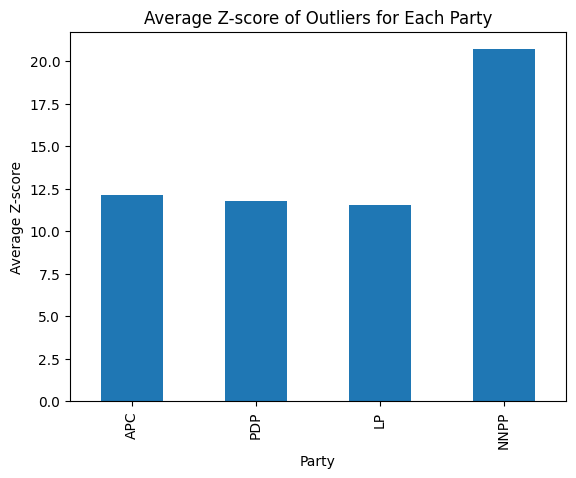

In [34]:
# prompt: find the average and std of the z value of apc. pdp, lp ,nnpp and make an error bar plot

# import matplotlib.pyplot as plt
# import pandas as pd



# Create a dictionary to store the data
data = {
    'Party': ['APC', 'PDP', 'LP', 'NNPP'],
    'mean': [apc_mean_z, pdp_mean_z, lp_mean_z, nnpp_mean_z],
    'std': [apc_std_z, pdp_std_z, lp_std_z, nnpp_std_z]
}

# Create a DataFrame
agg = pd.DataFrame(data)

# Create an error bar plot
agg.plot(kind='bar', x= 'Party',  y='mean', legend=False)
plt.xlabel('Party')
plt.ylabel('Average Z-score')
plt.title('Average Z-score of Outliers for Each Party')
plt.show()


### Conclusion
- NNPC has the highest number of polling unit with an irregularity
- NNPC also has the larges values in terms of how far these irregular vote counts rose.